# Linear Multivariate Regression for Heating Load Prediction
First we import packages and the data.

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, LinearRegression

data = pd.read_csv('heating_load.csv')
# features
X = data.loc[:, '# surface area (m^2)':'roof area  (m^2)']
# label
Y = data.loc[:, ['heating load (BTU)']]

In [76]:
print(data.head())

   # surface area (m^2)  wall area  (m^2)  roof area  (m^2)  \
0            515.087941        278.913968        113.206049   
1            484.327936        298.926749        117.495410   
2            524.353498        306.075683        107.707566   
3            538.651366        289.762611        110.584921   
4            555.025222        319.058201        120.406961   

   heating load (BTU)  
0           36.570041  
1           35.868318  
2           32.792317  
3           36.794874  
4           36.949919  


### Linear Regression without feature-engineering
The data is split into a testing set and a training set. The linear model is trained on the training set and validated on the testing set

In [77]:
def splitData(data, training_frac):
    train = data.sample(frac=training_frac, random_state=1).sort_index()
    test = data.drop(train.index)
    return train, test

In [78]:
train, test = splitData(data, 0.8)
train_X = train.loc[:, '# surface area (m^2)':'roof area  (m^2)']
train_Y = train.loc[:, ['heating load (BTU)']]
test_X = test.loc[:, '# surface area (m^2)':'roof area  (m^2)']
test_Y = test.loc[:, ['heating load (BTU)']]

linreg = LinearRegression()

linreg.fit(train_X, train_Y)
print(linreg.coef_)
pred_train = linreg.predict(train_X)
pred_test = linreg.predict(test_X)

print(mean_squared_error(train_Y, pred_train, squared=False))
print(mean_squared_error(test_Y, pred_test, squared=False))

[[-0.00238455  0.10729716 -0.19596588]]
3.559795406501676
3.792774310542606


The testing RMSE for normal linear regression is 3.7928

### Feature engineering and LASSO
Now we create some new features by combining the existing ones. Features are "chosen" by using a LASSO regression, which means some of the weights will be forced to zero.
The data is also normalized so that the magnitude of the features will not influence weather they are chosen to be a part of the model.

In [79]:
# feature engineering
data['theta1'] = data['# surface area (m^2)']*data['wall area  (m^2)']
data['theta2'] = data['# surface area (m^2)']*data['roof area  (m^2)']
data['theta3'] = data['wall area  (m^2)']*data['roof area  (m^2)']
data['theta4'] = np.log(data['# surface area (m^2)'])
data['theta5'] = np.log(data['wall area  (m^2)'])
data['theta6'] = np.log(data['roof area  (m^2)'])

# normalize data
data['theta1'] = data['theta1']/np.max(data['theta1'])
data['theta2'] = data['theta2']/np.max(data['theta2'])
data['theta3'] = data['theta3']/np.max(data['theta3'])
data['theta4'] = data['theta4']/np.max(data['theta4'])
data['theta5'] = data['theta5']/np.max(data['theta5'])
data['theta6'] = data['theta6']/np.max(data['theta6'])
data['# surface area (m^2)'] = data['# surface area (m^2)']/np.max(data['# surface area (m^2)'])
data['wall area  (m^2)'] = data['wall area  (m^2)']/np.max(data['wall area  (m^2)'])
data['roof area  (m^2)'] = data['roof area  (m^2)']/np.max(data['roof area  (m^2)'])

#rearrange cols
data.insert(0, 'heating load (BTU)', data.pop('heating load (BTU)'))

print(data.head())

   heating load (BTU)  # surface area (m^2)  wall area  (m^2)  \
0           36.570041              0.612569          0.637265   
1           35.868318              0.575988          0.682991   
2           32.792317              0.623588          0.699325   
3           36.794874              0.640592          0.662052   
4           36.949919              0.660064          0.728987   

   roof area  (m^2)    theta1    theta2    theta3    theta4    theta5  \
0          0.480028  0.448970  0.304654  0.356981  0.927226  0.925911   
1          0.498216  0.452449  0.297315  0.397092  0.918082  0.937306   
2          0.456713  0.501555  0.295071  0.372718  0.929873  0.941192   
3          0.468914  0.487771  0.311215  0.362279  0.933868  0.932186   
4          0.510562  0.553412  0.349157  0.434337  0.938314  0.948023   

     theta6  
0  0.865661  
1  0.872468  
2  0.856547  
3  0.861373  
4  0.876949  


### Finding optimal value of $\alpha$
We want alpha to be large as to minimize the number of features used, but not so large that the testing and training errors start to suffer. As is evident from the following results, for example setting alpha to 10 will yield all weights to be zero, giving us a useless model.

In [80]:
alphas = [0.00001, 0.0001, 0.001, 0.002, 0.005, 0.01, 0.1, 1, 10]

# splitting data into three sets, where val is used to validate the final chosen value of alpha
# when alpha has been chosen we train a Lasso regressor with that alpha with traintest
traintest, val = splitData(data, 0.8)
train, test = splitData(traintest, 0.8)
train_X = train.loc[:, '# surface area (m^2)':'theta6']
train_Y = train.loc[:, ['heating load (BTU)']]
test_X = test.loc[:, '# surface area (m^2)':'theta6']
test_Y = test.loc[:, ['heating load (BTU)']]
val_X = val.loc[:, '# surface area (m^2)':'theta6']
val_Y = val.loc[:, ['heating load (BTU)']]
traintest_X = traintest.loc[:, '# surface area (m^2)':'theta6']
traintest_Y = traintest.loc[:, ['heating load (BTU)']]

training_errors = []
testing_errors = []
for alpha in alphas:
    linreg = Lasso(alpha=alpha)

    linreg.fit(train_X, train_Y)
    print(linreg.coef_)
    pred_train = linreg.predict(train_X)
    pred_test = linreg.predict(test_X)

    training_errors.append(mean_squared_error(train_Y, pred_train, squared=False))
    testing_errors.append(mean_squared_error(test_Y, pred_test, squared=False))

print(training_errors)
print(testing_errors)


[  66.82693715  183.16118416   62.11210601   -0.98145177    5.07055491
  -65.77019527 -407.5326834  -341.78441402 -209.51567224]
[  42.27950174  165.50755688   66.35107715    8.38017974    7.308458
  -70.05499712 -328.04941333 -285.20181023 -218.98835637]
[ -55.83796459   90.0670051    63.71334255   37.93448092   24.23747345
  -89.42659829   -0.           -0.         -201.99028969]
[ -47.10637878  101.91910094   26.73765884   19.56420282   35.39403537
  -84.67698901   -0.           -0.         -113.70773687]
[ -3.93026156  94.24668036  -0.           0.           5.7689948
 -57.91474884  -0.          -0.         -13.7528811 ]
[ -0.          89.86082409  -2.48718472   0.          -0.
 -53.09764182  -0.           0.          -0.        ]
[ -0.          36.74537958 -46.08754036   0.          -0.
  -0.          -0.           0.          -0.        ]
[ -0.           0.         -12.37435377   0.         -12.88176409
  -0.          -0.           0.          -0.        ]
[-0.  0. -0.  0. -0. -0

/Users/tomhagander/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1681.1148268082059, tolerance: 6.958985519954824
  model = cd_fast.enet_coordinate_descent(
/Users/tomhagander/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 942.2161096357117, tolerance: 6.958985519954824
  model = cd_fast.enet_coordinate_descent(
/Users/tomhagander/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 274.9571940386868, tolerance: 6.958985519954824
  model = cd_fast.enet_coordinate_descent(
/Users/tomhagander/opt/anaconda3/lib/python3.8/site-pa

### Plotting errors
From here it is evident that setting alpha to 0.001 is a good choice

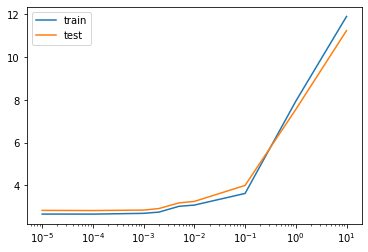

In [81]:
plt.plot(alphas, training_errors, label='train')
plt.plot(alphas, testing_errors, label='test')
plt.xscale('log')
plt.legend()

### Finding RMSE of best alpha

In [83]:
# best alpha at alpha = 0.001
linreg = Lasso(alpha = 0.001)
linreg.fit(traintest_X, traintest_Y)
pred = linreg.predict(val_X)
print(mean_squared_error(val_Y, pred, squared=False))

2.6845086210293907


/Users/tomhagander/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 283.5856869491686, tolerance: 8.51381899969923
  model = cd_fast.enet_coordinate_descent(


The regression with the engineered features is better than without engineering, as the resulting validation RMSE is 2.6856 which is lower than the RMSE of the simple linear regression.